#Installing and Importing Packages

In [ ]:
!pip install dwave.system
!pip install dwave.cloud
!pip install dwave.samplers

In [2]:
import numpy as np
from collections import defaultdict
from dimod import SimulatedAnnealingSampler
import random

# Постановка задачи
Есть n предметов и рюкзак. У каждого есть вес и стоимость. Наша задача - максимизировать стоимость предметов

#Brute Force

In [3]:
# items_values = {"⚽️": 8, "💻": 47, "📸": 10, "📚": 5, "🎸": 16}
# values_list = [8, 47, 10, 5, 16]

# items_weight = {"⚽️": 3, "💻": 11, "📸": 14, "📚": 19, "🎸": 5}
# weights_list = [3, 11, 14, 19, 5]

# maximum_weight = 26

# items_values = {"⚽️": 10, "💻": 10, "📸": 10, "📚": 10, "🎸": 10}
items_values = {i : i for i in range(random.randint(0, 10))}
values_list = [items_values[i] for i in range(len(items_values))]

items_weight = {i : i for i in range(random.randint(0, 10))}
weights_list = [items_values[i] for i in range(len(items_values))]

print(*values_list)
print(*weights_list)

maximum_weight = 50

0 1 2 3 4 5 6 7 8
0 1 2 3 4 5 6 7 8


In [4]:
def sum_weight(bitstring, items_weight):
    weight = 0
    for n, i in enumerate(items_weight):
        if bitstring[n] == "1":
            weight += i
    return weight


def sum_values(bitstring, items_value):
    value = 0
    for n, i in enumerate(items_value):
        if bitstring[n] == "1":
            value += i
    return value

items = list(items_values.keys())
n_items = len(items)
combinations = {}
max_value = 0
for case_i in range(2**n_items):  # all possible options
    combinations[case_i] = {}
    bitstring = np.binary_repr(
        case_i, n_items
    )  # bitstring representation of a possible combination, e.g, "01100" in our problem means bringing (-💻📸--)
    combinations[case_i]["items"] = [items[n] for n, i in enumerate(bitstring) if i == "1"]
    combinations[case_i]["value"] = sum_values(bitstring, values_list)
    combinations[case_i]["weight"] = sum_values(bitstring, weights_list)
    # save the information of the optimal solution (the one that maximizes the value while respecting the maximum weight)
    if (
        combinations[case_i]["value"] > max_value
        and combinations[case_i]["weight"] <= maximum_weight
    ):
        max_value = combinations[case_i]["value"]
        optimal_solution = {
            "items": combinations[case_i]["items"],
            "value": combinations[case_i]["value"],
            "weight": combinations[case_i]["weight"],
        }


print(
    f"The best combination is {optimal_solution['items']} with a total value: {optimal_solution['value']} and total weight {optimal_solution['weight']} "
)

The best combination is [1, 2, 3, 4, 5, 6, 7, 8] with a total value: 36 and total weight 36 


In [5]:
# def time_to_solution(n, time_single_case):
#     """
#         n (int): number of variables
#         time_single_case (float): time to solve a single case
#     """
#     return time_single_case * 2 ** n

# time_per_case = 1e-9 # time to execute a single case in seconds
# sec_day = 3600 * 24 # seconds in a day
# sec_year = sec_day * 365 # seconds in a year

# print(
#     f"- For 10 items, 2^10 cases, we need {time_to_solution(2, time_per_case)} seconds."
# )

#QUBO Solution

In [6]:
items_values = {"⚽️": 8, "💻": 47, "📸": 10, "📚": 5, "🎸": 16}
values_list = [8, 47, 10, 5, 16]

items_weight = {"⚽️": 3, "💻": 11, "📸": 14, "📚": 19, "🎸": 5}
weights_list = [3, 11, 14, 19, 5]

max_weight = 26

In [7]:
def timer(ret=False):
    def wrapper(func):
        def wrapped(*args):
            start_time = time.perf_counter_ns()
            res = func(*args)
            ms = (time.perf_counter_ns() - start_time) * 1e-6

            if ret:
                return res, ms

            print(ms, "ms")
            return res

        return wrapped

    return wrapper

In [8]:
def make_qubo(costs, weights, max_weight):
    q = defaultdict(int)
    A = 2
    for i in range(len(weights)):
        if i < len(costs):
            q[(i, i)] += A * weights[i] * (weights[i] - 2 * max_weight) - costs[i]
        else:
            q[(i, i)] += A * weights[i] * (weights[i] - 2 * max_weight)
        for j in range(i + 1, len(weights)):
            q[(i, j)] += 2 * A * weights[i] * weights[j]
    return q

def solve_qubo(costs, weights, max_weight):
    q = make_qubo(costs, weights, max_weight)

    sampler = SimulatedAnnealingSampler()
    sampleset = sampler.sample_qubo(q)

    ans = sampleset.first.sample
    ans_array = [ans[i] for i in range(len(costs))]
    ans_weight = sum([ans_array[i] * weights[i] for i in range(len(costs))])
    ans_cost = sum([ans_array[i] * costs[i] for i in range(len(costs))])

    return ans_array, ans_weight, ans_cost

In [9]:
# 5
# 8 47 10 5 16
# 3 11 14 19 5
# 26

num_items = int(input())
costs = list(map(int, input().split()))
weights = list(map(int, input().split()))
max_weight = int(input())

n = round(np.ceil(np.log2(max_weight)))
weights += [2 ** i for i in range(n)]

make_qubo(costs, weights, max_weight)

ans_array, ans_weight, ans_cost = solve_qubo(costs, weights, max_weight);

print('Found vector: ', *ans_array)
print('Total cost: ', ans_cost)
print('Total weight: ', ans_weight)

5
8 47 10 5 16
3 11 14 19 5
26
Found vector:  1 1 0 0 1
Total cost:  71
Total weight:  19


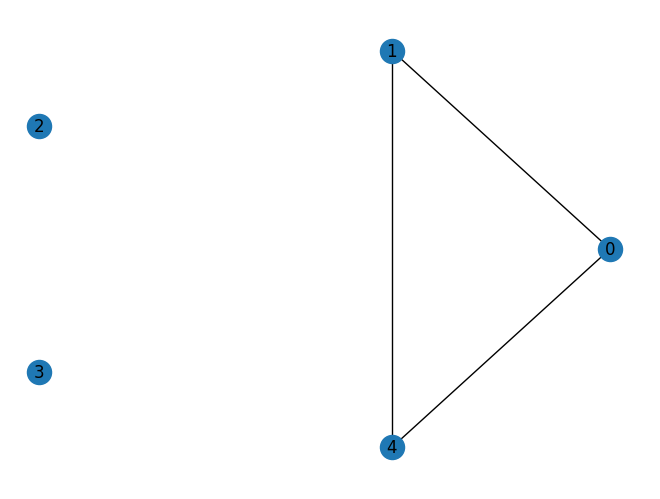

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

items = [i for i in range(num_items)] # все предметы (необязательно int, главное, чтобы хранились в list)
count = len(items)
# ans_vector = list(map(int, input().split())) # ответ на задачу
items_in_backpack = [items[i] for i in range(count) if ans_array[i]]

G.add_nodes_from(items)

if len(items_in_backpack) > 1:
    edges = [(items_in_backpack[i], items_in_backpack[i + 1]) for i in range(-1, len(items_in_backpack) - 1)]
    G.add_edges_from(edges)

nx.draw_circular(G, with_labels=True)
plt.show()